# Representing Data for Training RNNs in Keras
When we use recurrent networks, the most common form of data is text. In order to represent a sentence, we will need to make a few decisions. 
- Will our network fundamentally represent characters? Words? What are the building blocks for our structure?
- What is the maximum sequence length? 
- What is my maximum vocabulary size?
- What style of RNN should I use?
- Can I incorporate an Embedding? What size?
- What is my problem type? Many to one? Many to many? Sequence-to-Sequence?

A great tutorial that this notebook also uses as base code:
- http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

Let's start with the example above and see what the representation in Keras should look like. 

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences to be the same length
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

Using TensorFlow backend.


In [2]:
print(type(X_train),X_train.shape)
print(type(X_train[0]),X_train[0].shape)
print('Vocabulary size:', np.max(X_train))
print(y_train.shape, np.min(y_train), np.max(y_train))
NUM_CLASSES = 1

<class 'numpy.ndarray'> (25000, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 4999
(25000,) 0 1


The IMDB ratings data contains: a number of different reviews and the sentiment of the review as positive or negative. 

In [ ]:
# show example without the FOR loop
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=max_review_length)(input_holder) # number of words in each sequence


x = SimpleRNN(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [3]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=max_review_length)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 255,101.0
Trainable params: 255,101.0
Non-trainable params: 0.0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
___________________________________________________________

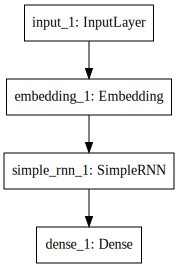

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

i=0
SVG(model_to_dot(rnns[i]).create(prog='dot', format='svg'))

In [25]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    rnn.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

======= simple ========
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 178s - loss: 0.7043 - acc: 0.5240 - val_loss: 0.6738 - val_acc: 0.5908

In [26]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('Round 2 training,',name,'========')
    rnn.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Round 2 training, simple ========
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 178s - loss: 0.5702 - acc: 0.6919 - val_loss: 0.5835 - val_acc: 0.6775

_____

# RNNs with Pre-processing in Keras

## Moving to 20 Newsgroups
So we should be able to convert a new dataset into the same format as above. Let's do this from scratch, converting the 20 news groups data. 
- http://qwone.com/~jason/20Newsgroups/

We looked at this a while back when we created the tf-idf and bag-of-words models. This time, we are not going to get rid of the sequence of words for classification. 

In [72]:
# convert 20 newsgroups into keras sequence format
from sklearn.datasets import fetch_20newsgroups
bunch = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [73]:
import numpy as np
idx = round(np.random.rand()*len(bunch.data))
print('Label: ',bunch.target_names[bunch.target[idx]])
print('================================')
print("\n".join(bunch.data[idx].split("\n")))

Label:  sci.crypt
From: tcmay@netcom.com (Timothy C. May)
Subject: Re: The Escrow Database.
Organization: NETCOM On-line Communication Services (408 241-9760 guest)
X-Newsreader: Tin 1.1 PL5
Lines: 41

Perry E. Metzger (pmetzger@snark.shearson.com) wrote:
: Here is a disturbing thought.
....good stuff elided....
: Don't pretend that no one unauthorized will ever get their hands on
: the escrow databases.
: 
.......
: secret. The escrow databases aren't the sorts of secrets that our
: teachers told us about, but they are the sort of big secrets they
: would lump into this category. Imagine trying to replace 100 million
: Clipper chips.

Sounds to me like a *great* gimmick for a replacement market...every
so often issue a "Clipper Alert" announcing that some key backup tapes
are missing, that some Drug Lords got 'em, whatever. Then the owners
of these $1200 Clipperphones have to trot down to their local Key
Escrow Agency and buy new chips and have them programmed.

Microtoxin, the Clippe

In [74]:
%%time
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(bunch.data)
sequences = tokenizer.texts_to_sequences(bunch.data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 134142 unique tokens. Distilled to 134142 top words.
Shape of data tensor: (11314, 1000)
Shape of label tensor: (11314, 20)
134141
CPU times: user 5.91 s, sys: 280 ms, total: 6.19 s
Wall time: 6.28 s


So that's it! The representation is now:
- each word is converted to an integer 
- each article is a series of integers that represent the correct ordering of words
- the target is one hot encoded

___

In [75]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=bunch.target, 
                                                            random_state=42)
NUM_CLASSES = 20
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(9051, 1000) (9051, 20)
[ 384.  467.  473.  472.  463.  474.  468.  475.  478.  478.  480.  476.
  473.  475.  474.  479.  437.  451.  372.  302.]


## Loading the embedding
But this is going to be a more involved process. Maybe we can speed up the training by loading up a pre-trained embedding of the words?!

Let's use the GloVe word embedding in keras. We will follow the example at:
- https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

You can download the nearly 1GB pretrained embeddings here:
- http://nlp.stanford.edu/data/glove.6B.zip

Let's take a quick look at the format of the file:

In [76]:
!ls "large_data/glove/" 

glove.6B.100d.txt glove.6B.200d.txt glove.6B.300d.txt glove.6B.50d.txt


In [1]:
!head "large_data/glove/glove.6B.100d.txt"

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [78]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(134143, 100)
CPU times: user 14.6 s, sys: 1.15 s, total: 15.8 s
Wall time: 16.3 s


In [79]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 1000, 100)         13414300  
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_30 (Dense)             (None, 20)                2020      
Total params: 13,496,720.0
Trainable params: 82,420.0
Non-trainable params: 13,414,300.0
_________________________________________________________________
None


In [81]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 9051 samples, validate on 2263 samples
Epoch 1/3
9051/9051 [==============================] - 683s - loss: 2.8614 - acc: 0.1062 - val_loss: 2.7280 - val_acc: 0.1281

In [82]:
# let's extend the training by a number of epochs
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 9051 samples, validate on 2263 samples
Epoch 1/3
9051/9051 [==============================] - 676s - loss: 2.3083 - acc: 0.2219 - val_loss: 2.2292 - val_acc: 0.2377

## [Back to Slides]

# From Recurrent back to Convolutional
Since all the sequences are now the same length, it is possible to construct a convolutional network on top of the embedded sequence outputs. Once embedded, there really is not too much difference in representation about the data and an image (though the data clearly has a different intuition). We will follow these steps:
- use an embedding layer to translate to a dense representation of the entire sequence
- train 1D filters to convolve with the output of the embedded sequence
 - note: 1D filters doesn't mean they are only one dimension, it means the filters are looped through in a single dimension. The size of the filter is [`kernel_size x embed_size`]. It loops through the entire embedding, over five words.
- hierarchically summarize the convolutions much like we did before with images

In [83]:
# but wait, if we are just making the sequences of this all the same size
#  can't we just use a 1-D convolutional network? 

from keras.models import Input, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Dense
from keras.layers.embeddings import Embedding

EMBED_SIZE = 100 
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(35)(x)  
x = Flatten()(x)
x = Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
preds = Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 1000, 100)         13414300  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 35, 128)           82048     
__________

In [84]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 118s - loss: 1.7843 - acc: 0.3579 - val_loss: 1.6191 - val_acc: 0.4145

In [85]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 119s - loss: 0.3390 - acc: 0.8827 - val_loss: 0.7541 - val_acc: 0.7861

In [86]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 118s - loss: 0.0789 - acc: 0.9832 - val_loss: 0.8226 - val_acc: 0.8277

Okay. So we seem to be maxing out the performance on the validation set. The results are pretty good--I would expect these to be about a top 10 submission on a class-based Kaggle competition. Nice!
- https://inclass.kaggle.com/c/cs5740-20-newsgroups-classification/leaderboard

# But others have done much better on 20 News groups! 

Why are we not getting the 95% on the data? Let's take a look at the original posting by the Keras blog. They claim that they get validation accuracy of 95% after two epochs!

Why are we not getting that same accuracy?  
- https://github.com/kimardenmiller/NLP_CNN/blob/master/Embeddings/0.0.4%20word%20index%20save.py

In [70]:
# from __future__ import print_function
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import sys
import pandas as pd
import pickle
from keras.models import load_model

np.random.seed(1337)

BASE_DIR = ''
GLOVE_DIR = 'large_data/glove'
TEXT_DATA_DIR = 'large_data/20news-bydate/20news-bydate-train/'
TEXT_DATA_DIR = 'large_data/20_newsgroups/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}

f = open('large_data/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# second, prepare text samples and their labels
print('Processing text data set')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label news_group to numeric id
labels = []  # list of label ids
for news_group in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, news_group)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[news_group] = label_id
        for post in sorted(os.listdir(path)):
            if post.isdigit():
                post_path = os.path.join(path, post)
                if sys.version_info < (3,):
                    f = open(post_path)
                else:
                    f = open(post_path, encoding='latin-1')
                texts.append(f.read())
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))
print(texts[0])

# override with sklearn
# texts = bunch.data
# labels = bunch.target
# labels_index = bunch.target_names

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
pickle.dump(tokenizer, open('large_data/tokenizer.004.p', 'wb'))
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print('Word index', word_index.values())

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Sample data tensor:', data[0, 0:])
print('Shape of label tensor:', labels.shape)
print('Sample label tensor:', labels[690:750, 0:])
# sys.exit()

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=2, batch_size=128)

#  Dec 30, 2016  loss: 0.3069 - acc: 0.8908 - val_loss: 0.1421 - val_acc: 0.9549

# # First evaluation of the model
# scores = model.evaluate(x_val, y_val, verbose=0)
# print("Accuracy of Run Model: %.2f%%" % (scores[1]*100))

# model.save('../saved_models/0.0.4_model.h5')
# np.save('../saved_models/0.0.4_word_index.npy', word_index)

# del model  # deletes the existing model

# # returns a compiled model identical to the previous one
# model = load_model('../saved_models/0.0.4_model.h5')

# # Final evaluation of the model
# scores = model.evaluate(x_val, y_val, verbose=0)
# print("Accuracy of Disk-Loaded Model: %.2f%%" % (scores[1]*100))

Indexing word vectors.
Processing text data set
Found 19997 texts.
Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Atheist Resources
Summary: Books, addresses, music -- anything related to atheism
Keywords: FAQ, atheism, books, music, fiction, addresses, contacts
Message-ID: <19930329115719@mantis.co.uk>
Date: Mon, 29 Mar 1993 11:57:19 GMT
Expires: Thu, 29 Apr 1993 11:57:19 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930301143317@mantis.co.uk>
Lines: 290

Archive-name: atheism/resou

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/keras/preprocessing/text.py:89: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 214873 unique tokens.
Shape of data tensor: (19997, 1000)
Sample data tensor: [  447   119   489   755    76   696  2362    10    76   118  3007    83
   814     4   216    76  7208 16127  7084   126     1   516    25     4
    83  9295 12513  7994     5  3773  7097     5   393     4   719     6
   933     3     5  1891  2154     3  2977     5  7449    18 13741     1
    97     1  7097  4952     3  2842   807    18     1  7994  1249     9
  3477     3 15061     5 10707     6  7469  9926     5     4   760    14
   234  2234     4     5   489   480   188     1 11088  8086    14     1
  4304 11974     4  1131   226  1483     9  3096   186   126  2129    47
     5  6103  2438  5693     4  3144    35  1768  3639  3058    76     9
 13222    47   126 18603     6  2056  1226     6 15022   108  3903  3798
     1  3639  5090   216   719    47   742     5  1044  2066  8364    28
   423  5236    18   325  2062   159  1509   423     9  5744     6   314
    23 11655    47     5   859   451  14

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:148: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15998 samples, validate on 3999 samples
Epoch 1/2
15998/15998 [==============================] - 281s - loss: 1.9110 - acc: 0.3264 - val_loss: 0.9826 - val_acc: 0.6387

In [71]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=2, batch_size=128)

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 15998 samples, validate on 3999 samples
Epoch 1/2
15998/15998 [==============================] - 255s - loss: 0.3346 - acc: 0.9032 - val_loss: 0.2218 - val_acc: 0.9345